# TP Laboratorio de Implementación 2 - EDA

In [ ]:
# pip install pingouin

Note: you may need to restart the kernel to use updated packages.


## Librerias y Funciones Definidas

In [7]:
# Importamos librerias
import os
os.environ["MKL_DEBUG_CPU_TYPE"] = "5" # Para evitar el error de mkl en MacOS
os.chdir('C:/Users/adria/Documents/Adrián/AUSTRAL/2025 - 1er Bimestre - Laboratorio de Implementación II/TPs/UA_MDM_Labo2/petfinder-adoption-prediction')

# Carga de Librerias
# Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de palabras
from wordcloud import WordCloud, STOPWORDS

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

# Pingouin
import pingouin as pg

In [8]:
# Función para mostrar todos los gráficos de distribución para una variable
def graficos_distribucion(df, variable):
    plt.figure(figsize=(15, 4))

    # Histograma + KDE
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], kde=True)
    plt.title(f"Histograma de {variable}")
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title(f"Boxplot de {variable}")
    plt.xlabel(variable)

    # QQ Plot
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"QQ Plot de {variable}")

    plt.tight_layout()
    plt.show()

In [9]:
# Función para aplicar distintos tests de normalidad y graficar
def analizar_normalidad(df, variable):
    print(f"\n--- Normalidad para {variable} ---")

    # Shapiro-Wilk Test
    stat, p = shapiro(df[variable])
    print(f"Shapiro-Wilk: W={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")
    
    # D'Agostino and Pearson's test
    stat, p = normaltest(df[variable])
    print(f"D’Agostino-Pearson: stat={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")

    # Anderson-Darling Test
    result = anderson(df[variable])
    print(f"Anderson-Darling: A={result.statistic:.4f}")
    for i in range(len(result.critical_values)):
        sig = result.significance_level[i]
        crit = result.critical_values[i]
        print(f"  Nivel {sig}%: crítico={crit:.4f} {'-> No normal' if result.statistic > crit else '-> Normal'}")


## Carga de Datos

In [11]:
# Carga de .csv
df = pd.read_csv('train/train.csv')
df_breed_labels = pd.read_csv('breed_labels.csv')
df_color_labels = pd.read_csv('color_labels.csv')
df_state_labels = pd.read_csv('state_labels.csv')


In [13]:
# Inspección de los datos
df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   
3             2  ...       1         1  150  41401   
4             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

## Análisis Univariado

### `Type`

In [23]:
# Valores nulos
df.Type.isna().sum()

0

In [24]:
# Valores únicos
df.Type.value_counts().sort_index()

Type
1    8132
2    6861
Name: count, dtype: int64

In [25]:
# Creamos una columna descriptiva de 'Type'
type_map = {1: 'dog', 2: 'cat'}

df['type_df'] = df['Type'].map(type_map)

In [26]:
# Valores únicos con etiquetas
df.type_df.value_counts().sort_values(ascending=False)

type_df
dog    8132
cat    6861
Name: count, dtype: int64

In [27]:
# Proporción de Valores únicos
df.type_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

type_df
dog    0.54
cat    0.46
Name: proportion, dtype: float64

<Axes: xlabel='type_df'>

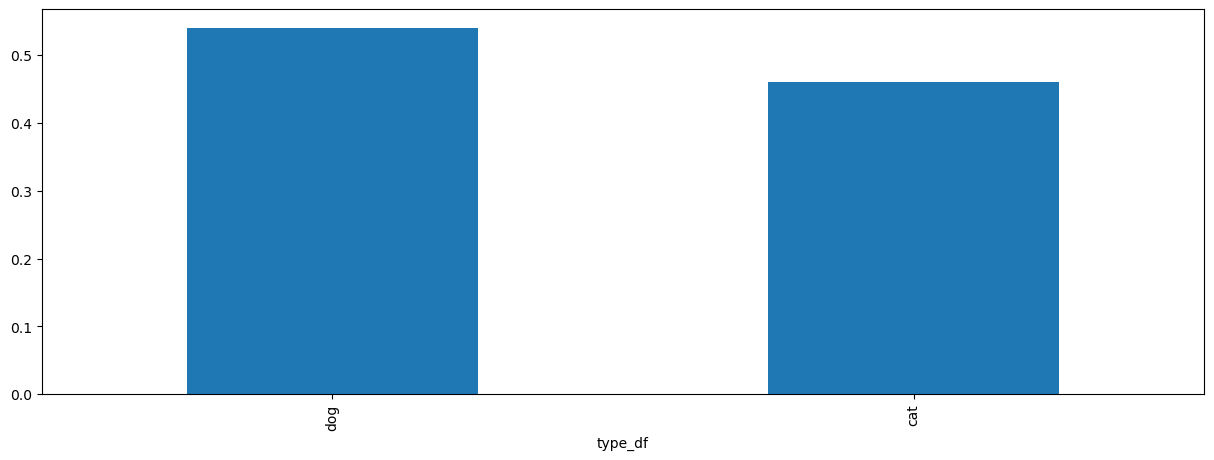

In [28]:
# Gráfico de Valores únicos con etiquetas
df.type_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Type
- No hay valores nulos



### Age

In [30]:
# Valores de tendencia central y dispersión
df.Age.describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

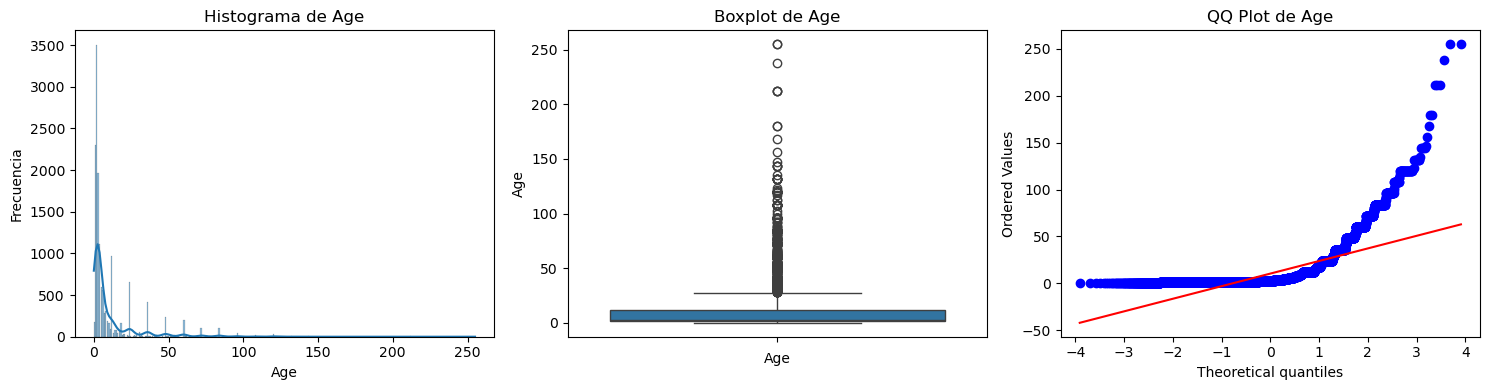

In [31]:
# Gráficos de distribución
graficos_distribucion(df, 'Age')

In [32]:
# Test de normalidad    
analizar_normalidad(df, 'Age')


--- Normalidad para Age ---
Shapiro-Wilk: W=0.5466, p=0.0000 -> No normal
D’Agostino-Pearson: stat=12029.5416, p=0.0000 -> No normal
Anderson-Darling: A=2304.0481
  Nivel 15.0%: crítico=0.5760 -> No normal
  Nivel 10.0%: crítico=0.6560 -> No normal
  Nivel 5.0%: crítico=0.7870 -> No normal
  Nivel 2.5%: crítico=0.9180 -> No normal
  Nivel 1.0%: crítico=1.0920 -> No normal


c:\Users\adria\anaconda3\envs\ldi2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14993.
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
# Valores nulos
df.Age.isna().sum()   

0

In [35]:
# Valores negativos
df['Age'][df['Age']<0].count()

0

El campo `Age` muestra una distribución no normal, sin valores nulos o negativos.

### Breed1
Se agregan dos campos `BreedName1 y BreedName2` que corresponde a las etiquetas de BreedName del archivo `breed_labels.csv`. A lo mejor pueden servir tener las etiquetas.


In [36]:
# Crear un diccionario de mapeo de BreedID a BreedName
breed_dict = df_breed_labels.set_index('BreedID')['BreedName'].to_dict()

# Agregar una nueva columna 'BreedName' en df_train mapeando 'Breed1'
df['BreedName1'] = df['Breed1'].map(breed_dict)

# Mostrar las primeras filas para verificar
df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Fee  State                         RescuerID  VideoAmt  \
0             1  ...  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1             2  ...    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2             2  ...    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3             2  ...  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4             2  ...    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906       7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90       3.0   

   AdoptionSpeed type_df            BreedName1  
0              2     cat                 Tabby  
1              0     cat  Domestic Medium Hair  
2              3     dog           Mixed Breed  
3              2     dog           Mixed Breed  
4              2     dog           Mixed Breed  

[5 rows x 26 columns]

In [37]:
# Agregar una nueva columna 'BreedName' en df_train mapeando 'Breed2'
df['BreedName2'] = df['Breed2'].map(breed_dict)

# Mostrar las primeras filas para verificar
df.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  State                         RescuerID  VideoAmt  \
0             1  ...  41326  8480853f516546f6cf33aa88cd76c379         0   
1             2  ...  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2             2  ...  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3             2  ...  41401  9238e4f44c71a75282e62f7136c6b240         0   
4             2  ...  41326  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906       7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90       3.0   

   AdoptionSpeed  type_df            BreedName1  BreedName2  
0              2      cat                 Tabby         NaN  
1              0      cat  Domestic Medium Hair         NaN  
2              3      dog           Mixed Breed         NaN  
3              2      dog           Mixed Breed         NaN  
4              2      dog           Mixed Breed         NaN  

[5 rows x 27 columns]

#### Valores Nulos

In [39]:
# Valores nulos en BreedName1 y ver si se corresponden con un nulo de BreedName2
df[['BreedName1', 'BreedName2']][df['BreedName1'].isna()]

BreedName1                 BreedName2
391         NaN  Belgian Shepherd Malinois
1045        NaN                Mixed Breed
3219        NaN        Domestic Short Hair
7285        NaN                Mixed Breed
7706        NaN                   Shih Tzu

In [40]:
# Quiere adoptar ??
df.Description.iloc[7706]

'I want to adopt a newborn puppy Prefer small breed,mix breed Mongreal also can Prefere female puppy If u dun have time to takecare them,can give me Im a dog lover Can sms/ call me Jb area.. Jb area'

Breed1 y Breed2 se refieren a la raza.
En el dataset PetFinder.my se registra información sobre las razas de las mascotas mediante dos columnas:
- Breed1:
	- Representa la raza principal de la mascota. Sin embargo, en algunos registros este campo puede aparecer como NaN. Esto suele ocurrir por dos razones principales:
		1.	Datos faltantes o errores en el registro: Es posible que, al momento de la recolección de datos, no se haya podido identificar o registrar de forma confiable la raza principal de la mascota.
		2.	Casos particulares en la clasificación: En situaciones donde la determinación de una raza principal no es clara (por ejemplo, en animales de mezcla sin una predominancia evidente), puede suceder que se deje sin especificar.

- Breed2:
	- Se utiliza para indicar la segunda raza en caso de que la mascota sea de raza mixta. Una convención común en el dataset es que, incluso para animales que son de raza pura, este campo se asigna con un valor por defecto (por ejemplo, 0 o algún otro código) en lugar de quedar como NaN. Esto se hace para mantener la consistencia en la estructura de datos y facilitar el análisis, ya que siempre se dispone de un valor en Breed2.

Entender cómo se registran Breed1 y Breed2 y las razones por las que pueden tener comportamientos distintos (falta de datos en el primero y valores por defecto en el segundo) es crucial para un EDA robusto y para derivar conclusiones significativas sobre las características de las mascotas en el dataset. 

Consideraciones acerca de las razas puras:
- Mascotas de raza pura:
	- Lo habitual es que se registre la raza principal en Breed1 y que Breed2 se deje vacío o se asigne un valor predeterminado (por ejemplo, 0 o un código específico) para indicar que no hay una segunda raza. En otras palabras, no se espera que Breed2 “coincida” con Breed1 en un sentido literal, sino que se utiliza un valor nulo o por defecto para señalar que el animal es de una única raza.
- Mascotas de mezcla:
	- En estos casos, Breed1 suele representar la raza predominante, mientras que Breed2 contiene la segunda raza identificada.

Aunque en algunos datasets se podría haber optado por duplicar la raza en ambos campos para indicar pureza, lo más común y lógico es que en animales de raza pura solo se use Breed1 y Breed2 se mantenga sin valor significativo. Esto ayuda a diferenciar de manera clara entre animales de raza pura y de mezcla durante el análisis exploratorio (EDA).

In [41]:
# De querer tratar los valores nulos de BreedName1 con BreedName2
# df['BreedName1'] = df['BreedName1'].fillna(df['BreedName2'])

#### Valores por tipo de raza, se destacan los nombres de razas con más de 100 unidades

#### Análisis descriptivo   

In [42]:
# BreedName1 con más de 100 unidades
df.BreedName1.value_counts()[df.BreedName1.value_counts() > 100] 

BreedName1
Mixed Breed             5927
Domestic Short Hair     3634
Domestic Medium Hair    1258
Tabby                    342
Domestic Long Hair       296
Siamese                  264
Persian                  221
Labrador Retriever       205
Shih Tzu                 190
Poodle                   167
Terrier                  162
Golden Retriever         151
Calico                   105
Name: count, dtype: int64

<Axes: xlabel='BreedName1'>

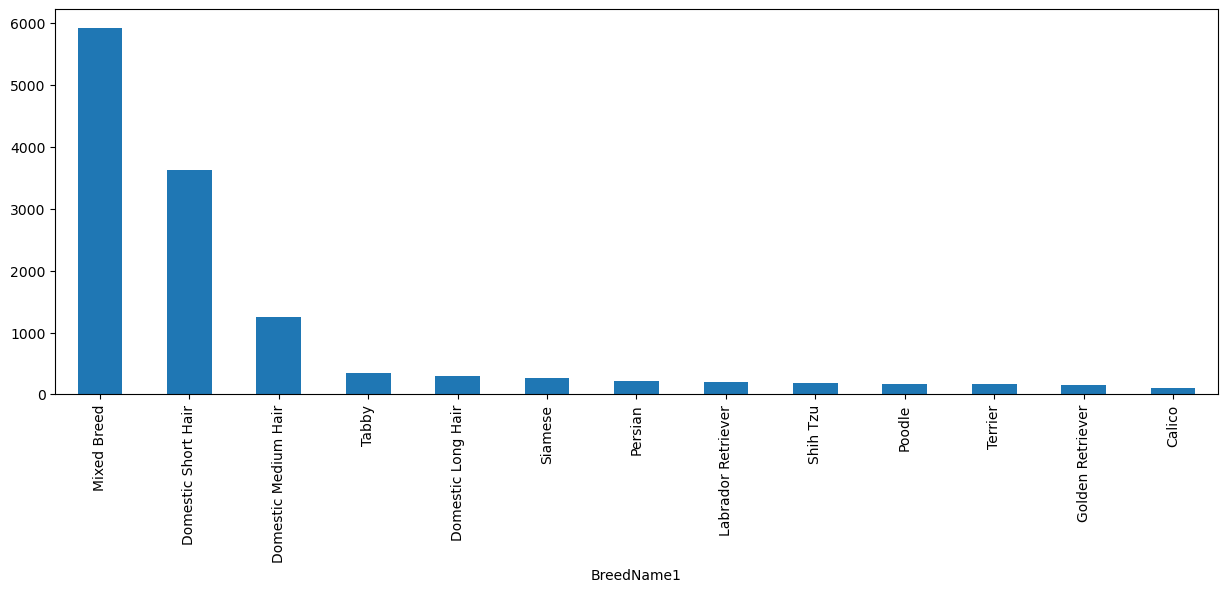

In [43]:
# Graficaos BreedName1 con más de 100 unidades
df.BreedName1.value_counts()[df.BreedName1.value_counts() > 100].plot(kind='bar', figsize=(15, 5))  


Destaca que el valor más frecuente es 'Mixed Breed' una suerte de comodín de descripción de razas.  

Las descripciones “Domestic Short Hair”, “Domestic Medium Hair” o “Domestic Long Hair” son utilizadas de forma genérica para referirse a animales (especialmente gatos) que no tienen una raza definida o registrada. Es decir, estos términos se aplican a mascotas de origen mixto o sin pedigrí, donde la única característica distintiva es la longitud del pelaje, en lugar de corresponder a un linaje o raza específica. Estos términos para los gatos son comunes en refugios y bases de datos para distinguir la apariencia del pelaje de los gatos sin pedigrí. No implican que el animal tenga una mezcla de razas específica, sino simplemente que es un gato de pelo corto, medio o largo. En perros se suele usar "Mixed Breed". 

“Tabby” no es una raza en sí misma, sino un patrón de pelaje que se observa comúnmente en los gatos domésticos. Este patrón se caracteriza por tener rayas, manchas o remolinos en el pelaje. 

### `Gender`

#### Valores Nulos

In [44]:
# Valores nulos
df.Gender.isna().sum()

0

#### Análisis Descriptivo

In [45]:
# Valores únicos
df.Gender.value_counts().sort_index()

Gender
1    5536
2    7277
3    2180
Name: count, dtype: int64

In [46]:
# Creamos una columna descriptiva de 'Gender'
gender_map = {1: 'male', 2: 'female', 3: 'mixed'}

df['gender_df'] = df['Gender'].map(gender_map)

In [47]:
# Valores únicos con etiquetas
df.gender_df.value_counts().sort_index()

gender_df
female    7277
male      5536
mixed     2180
Name: count, dtype: int64

In [48]:
# Proporción de Valores únicos
df.gender_df.value_counts(normalize=True).round(2).sort_index()

gender_df
female    0.49
male      0.37
mixed     0.15
Name: proportion, dtype: float64

<Axes: xlabel='gender_df'>

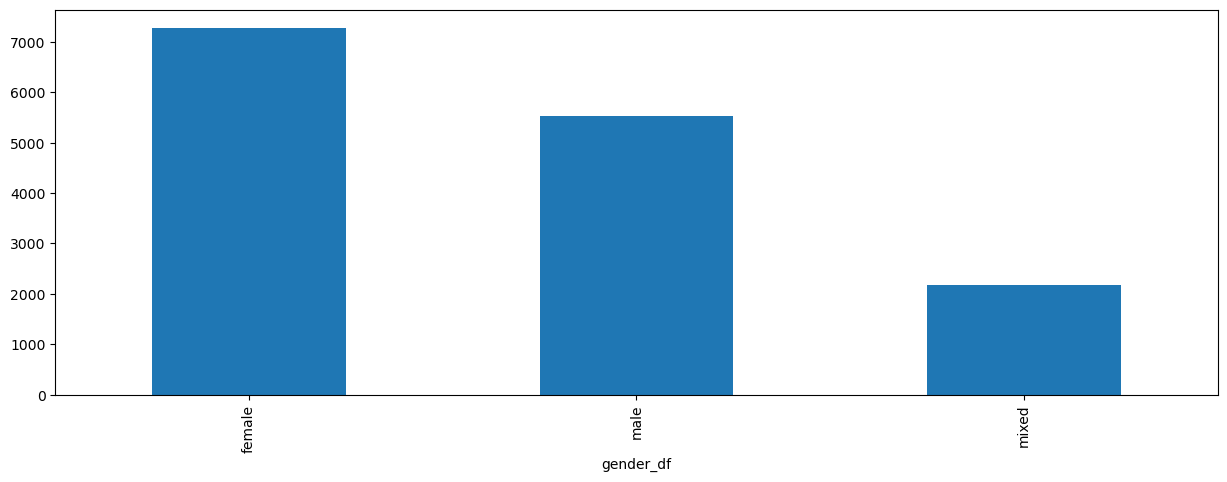

In [49]:
# Gráfico de Valores únicos con etiquetas
df.gender_df.value_counts().plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Gender
- No hay valores nulos
- El valor más frecuente (moda) es 'female'
- En algunos contextos, la categoría “mixed” puede requerir una interpretación particular, ya que puede indicar incertidumbre o una mezcla real de géneros en el caso de que se traran de grupos. (verificar esto con otros datos)

### `Color1, Color2, Color3`

#### Valores nulos

In [50]:
# Buscamos valores nulos en el primer campo Color
df.Color1.isna().sum()

0

Hay tres campos Color, el campo Color1 no contiene valores nulos, los otros dos sí pero es lógico porque puede haber un animal de un único color. 

#### Uniificación de criterios en Color

In [55]:
# Campo descriptivo del color, podría servir
df['Color1_d'] = df['Color1'].map(df_color_labels.set_index('ColorID')['ColorName'])
df['Color2_d'] = df['Color2'].map(df_color_labels.set_index('ColorID')['ColorName'])
df['Color3_d'] = df['Color3'].map(df_color_labels.set_index('ColorID')['ColorName'])

In [56]:
# Creamos una copia con los campos requeridos
df_Color_d = df[['Color1_d', 'Color2_d', 'Color3_d']].copy()

In [57]:
# Verificamos coincidencias de colores entre los tres campos
df_Color_d['Color1_d'][(df_Color_d['Color1_d']==df['Color2_d'])
                     | (df_Color_d['Color1_d']==df['Color3_d'])
                     | (df_Color_d['Color2_d']==df['Color3_d'])].count()

0

In [58]:
# Creamos un campo color_n que contabiliza la cantidad de colores por fila
df['color_n'] = (df[['Color1', 'Color2', 'Color3']]>0).sum(axis=1)

# Verificar el resultado
print(df[['Color1', 'Color2', 'Color3', 'color_n']].head())

   Color1  Color2  Color3  color_n
0       1       7       0        2
1       1       2       0        2
2       2       7       0        2
3       1       2       0        2
4       1       0       0        1


In [59]:
# Verificar la cantidad de filas agrupados por cantidad de colores
df.color_n.value_counts().sort_index()

color_n
1    4471
2    6133
3    4389
Name: count, dtype: int64

In [60]:
# Verificar la cantidad de filas agrupados por cantidad de colores
df.color_n.value_counts(normalize=True).round(3).sort_index()

color_n
1    0.298
2    0.409
3    0.293
Name: proportion, dtype: float64

Esto podria servir para ver si animales de distintos colores se adoptan más

<Axes: xlabel='color_n'>

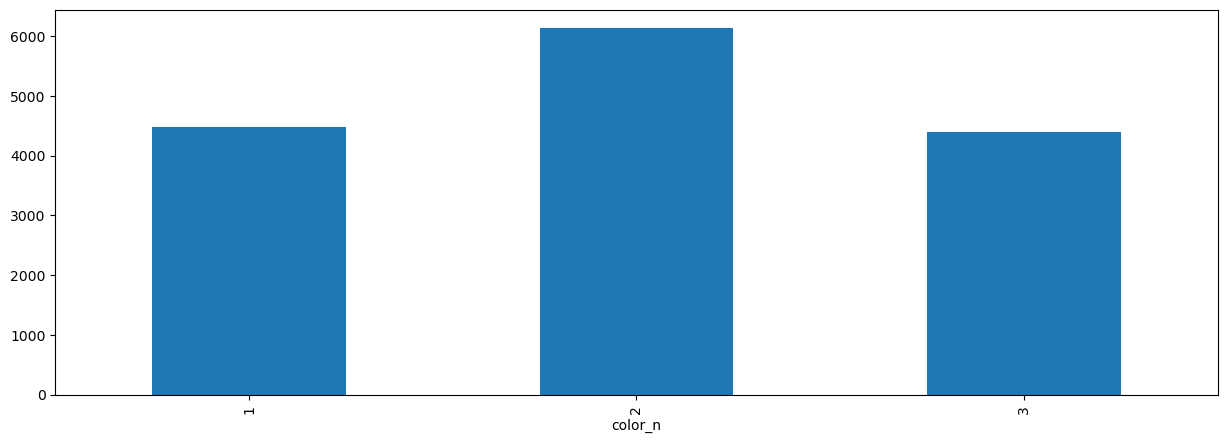

In [61]:
df.color_n.value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

En el 40% de los casos firguran animales de dos colores, resultado de uno y tres colores 30% respectivamente.

## `MaturitySize`
El campo MaturitySize indica el tamaño que se espera que tenga la mascota una vez que ha alcanzado su madurez. En el contexto del dataset PetFinder.my, este campo suele codificarse de forma ordinal (por ejemplo, valores numéricos que representan “pequeño”, “mediano”, “grande” o incluso una escala más detallada) y permite distinguir entre mascotas que, al madurar, serán de menor o mayor tamaño.

Utilidad en el EDA
	- Segmentación:
Permite agrupar a los animales según su tamaño maduro, lo que puede ser relevante para analizar comportamientos de adopción, necesidades de espacio, o preferencias de los adoptantes.
	- Relación con Otras Variables:
Al cruzarlo con otras características (como la raza, la edad o el tipo de mascota), se pueden identificar patrones o correlaciones interesantes. Por ejemplo, quizá las mascotas de mayor tamaño se adopten a diferentes ritmos que las de menor tamaño.
	•- Perfil del Animal:
Conocer el tamaño maduro ayuda a construir un perfil más completo de la mascota, lo que puede influir en decisiones de marketing o en la creación de estrategias específicas para diferentes segmentos de animales.

MaturitySize es una variable clave para comprender las expectativas de tamaño de las mascotas y su posible impacto en otros aspectos del comportamiento de adopción o en el manejo de los animales.

In [62]:
# Valores nulos
df.MaturitySize.isna().sum()

0

In [63]:
# Valores únicos
df.MaturitySize.value_counts().sort_index() 


MaturitySize
1     3395
2    10305
3     1260
4       33
Name: count, dtype: int64

In [68]:
# Creamos una columna descriptiva de 'MaturitySize'
maturitysize_map = {1: 'pequeño', 2: 'mediano', 3: 'grande', 4: 'muy grande'}

df['maturitysize_df'] = df['MaturitySize'].map(maturitysize_map)

In [72]:
# Valores únicos con etiquetas
df.maturitysize_df.value_counts().sort_index()

maturitysize_df
grande         1260
mediano       10305
muy grande       33
pequeño        3395
Name: count, dtype: int64

In [73]:
# Proporción de Valores únicos
df.maturitysize_df.value_counts(normalize=True).round(2).sort_index()

maturitysize_df
grande        0.08
mediano       0.69
muy grande    0.00
pequeño       0.23
Name: proportion, dtype: float64

<Axes: xlabel='maturitysize_df'>

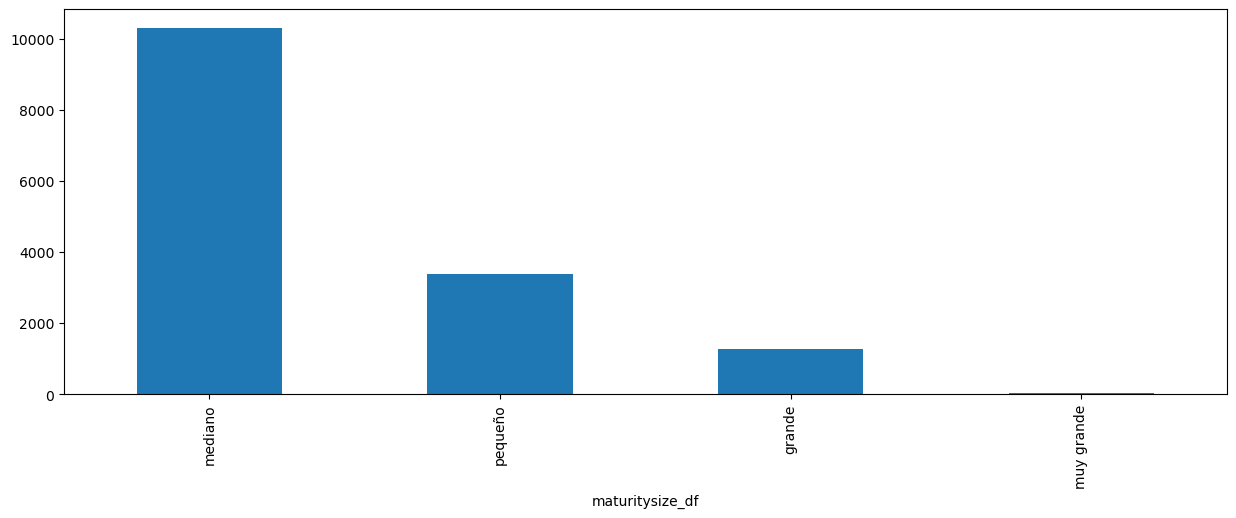

In [45]:
# Gráfico de Valores únicos con etiquetas
df.maturitysize_df.value_counts().plot(kind='bar', figsize=(15, 5))

En este dataset la variable `MaturitySize` (tamaño en la madurez), se concentra mayoritariamente en los valores “mediano” y “pequeño”, con una proporción reducida de “grande” y “muy grande”. Esto sugiere que la mayoría de las mascotas en la base de datos no llegan a un tamaño grande en la edad adulta, lo cual puede ser un factor relevante para entender la oferta de mascotas y los patrones de adopción.

## `FurLength`
La variable `FurLength` se refiere a la longitud del pelaje de la mascota. Es una variable ordinal categórica codificada numéricamente, que describe si el animal tiene el pelo corto, mediano o largo.

Codificación habitual:
- 1: Pelaje corto (Short)
- 2: Pelaje mediano (Medium)
- 3: Pelaje largo (Long)


In [74]:
# Creamos una columna descriptiva de 'FurLength'
furlength_map = {1: 'corto', 2: 'mediano', 3: 'largo'}

df['furlength_df'] = df['FurLength'].map(furlength_map)

In [75]:
# Valores Nulos
df.FurLength.isna().sum()

0

In [76]:
df.FurLength.value_counts().sort_index()

FurLength
1    8808
2    5361
3     824
Name: count, dtype: int64

In [77]:
# Proporción de Valores únicos
df.FurLength.value_counts(normalize=True).round(2).sort_index()

FurLength
1    0.59
2    0.36
3    0.05
Name: proportion, dtype: float64

<Axes: xlabel='furlength_df'>

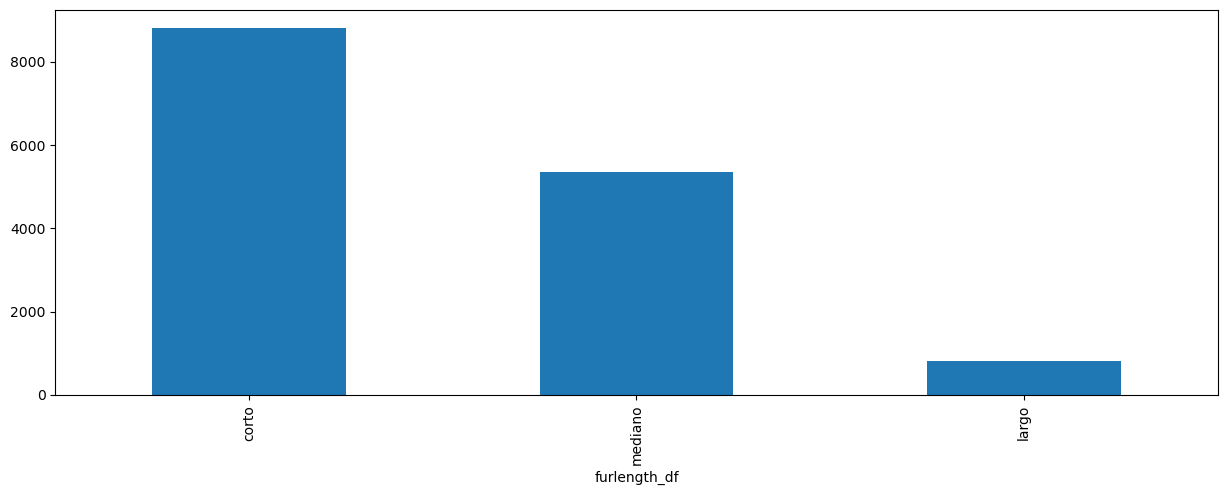

In [78]:
# Gráfico de Valores únicos con etiquetas
df.furlength_df.value_counts().plot(kind='bar', figsize=(15, 5))

`FurLength` es una variable descriptiva del aspecto físico del animal que puede ser relevante tanto para fines analíticos como para modelos predictivos relacionados con adopción.

Su objetivo es indicar visual y funcionalmente cómo es el pelaje del animal, lo cual puede influir en:
- Preferencias de adopción (algunas personas prefieren mascotas de pelo corto por menor mantenimiento).
- Cuidados requeridos (pelajes largos requieren más higiene y cepillado).
- Percepción estética o de raza (algunas razas se asocian con cierto tipo de pelaje).

### `Vaccinated`

In [79]:
# Valores nulos
df.Vaccinated.isna().sum()

0

In [80]:
# Valores únicos
df.Vaccinated.value_counts().sort_index()

Vaccinated
1    5898
2    7227
3    1868
Name: count, dtype: int64

In [81]:
# Creamos una columna descriptiva de 'Vaccinated'
vaccinated_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['vaccinated_df'] = df['Vaccinated'].map(vaccinated_map)

In [82]:
# Valores únicos con etiquetas
df.vaccinated_df.value_counts().sort_values(ascending=False)

vaccinated_df
no          7227
yes         5898
not sure    1868
Name: count, dtype: int64

In [83]:
# Proporción de Valores únicos
df.vaccinated_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

vaccinated_df
no          0.48
yes         0.39
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='vaccinated_df'>

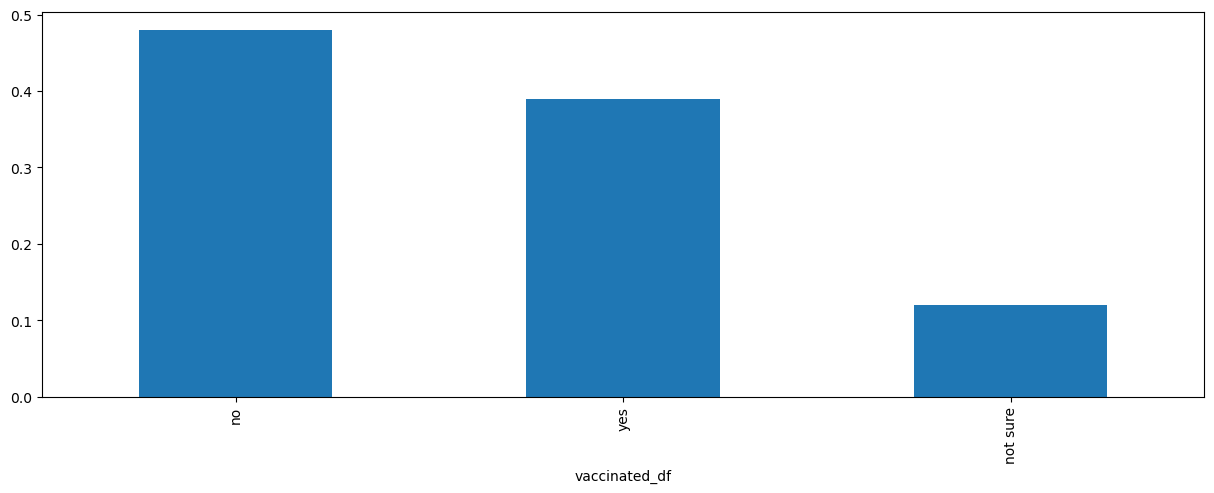

In [84]:
# Gráfico de Valores únicos con etiquetas
df.vaccinated_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Vaccinated
- No hay valores nulos
- El valor más frecuente (moda) es 'no', seguido por 'yes', alrededor del 10% no hay seguridad.


### `Dewormed`

In [85]:
# Valores nulos
df.Dewormed.isna().sum()

0

In [86]:
# Valores únicos
df.Dewormed.value_counts().sort_index()

Dewormed
1    8397
2    4815
3    1781
Name: count, dtype: int64

In [87]:
# Creamos una columna descriptiva de 'Dewormed'
dewormed_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['dewormed_df'] = df['Dewormed'].map(dewormed_map)

In [88]:
# Valores únicos con etiquetas
df.dewormed_df.value_counts().sort_values(ascending=False)

dewormed_df
yes         8397
no          4815
not sure    1781
Name: count, dtype: int64

In [89]:
# Proporción de Valores únicos
df.dewormed_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

dewormed_df
yes         0.56
no          0.32
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='dewormed_df'>

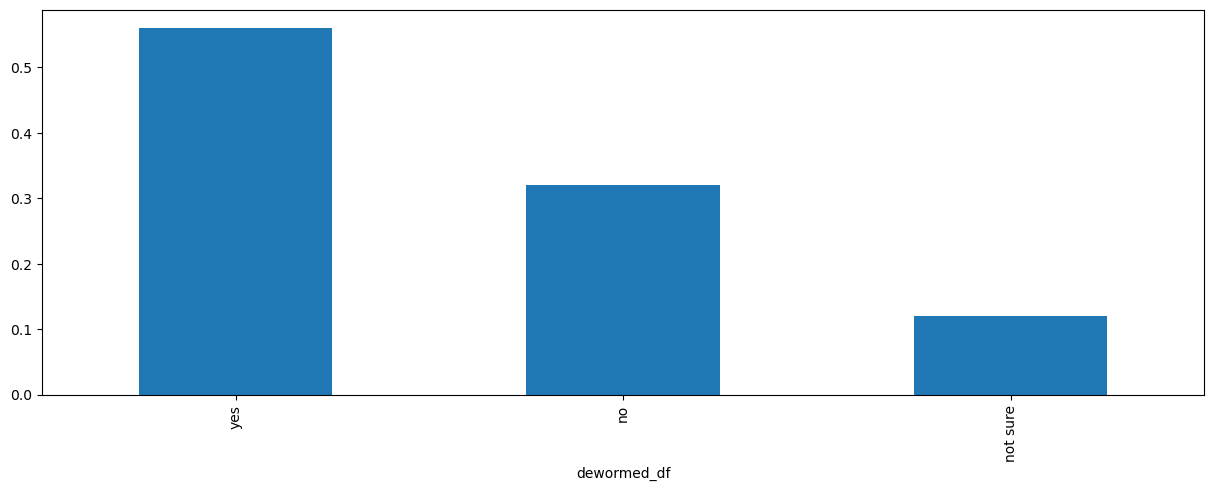

In [90]:
# Gráfico de Valores únicos con etiquetas
df.dewormed_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Dewormed
- No hay valores nulos
- El valor más frecuente (moda) es 'yes', seguido por 'no', alrededor del 10% no hay seguridad.


### `Sterilized`

In [91]:
# Valores nulos
df.Sterilized.isna().sum()

0

In [92]:
# Valores únicos
df.Sterilized.value_counts().sort_index()

Sterilized
1     3101
2    10077
3     1815
Name: count, dtype: int64

In [93]:
# Creamos una columna descriptiva de 'Sterilized'
sterilized_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['sterilized_df'] = df['Sterilized'].map(sterilized_map)

In [94]:
# Valores únicos con etiquetas
df.sterilized_df.value_counts().sort_values(ascending=False)

sterilized_df
no          10077
yes          3101
not sure     1815
Name: count, dtype: int64

In [95]:
# Proporción de Valores únicos
df.sterilized_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

sterilized_df
no          0.67
yes         0.21
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='sterilized_df'>

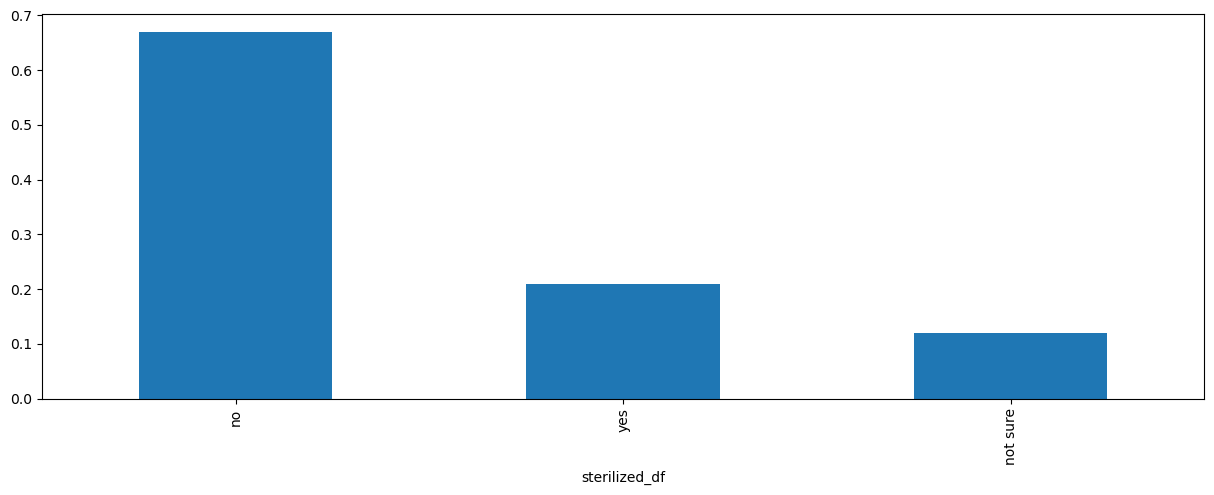

In [96]:
# Gráfico de Valores únicos con etiquetas
df.sterilized_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Sterilized
- No hay valores nulos
- El valor más frecuente (moda) es 'no', seguido por 'yes' en un 20%, alrededor del 10% no hay seguridad.


### `Health`

In [97]:
# Valores nulos
df.Health.isna().sum()

0

In [98]:
# Valores únicos
df.Health.value_counts().sort_index()

Health
1    14478
2      481
3       34
Name: count, dtype: int64

In [99]:
# Creamos una columna descriptiva de 'Health'
health_map = {1: 'healthy', 2: 'minor', 3: 'serious'}

df['health_df'] = df['Health'].map(health_map)

In [100]:
# Valores únicos con etiquetas
df.health_df.value_counts().sort_values(ascending=False)

health_df
healthy    14478
minor        481
serious       34
Name: count, dtype: int64

In [101]:
# Proporción de Valores únicos
df.health_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

health_df
healthy    0.97
minor      0.03
serious    0.00
Name: proportion, dtype: float64

<Axes: xlabel='health_df'>

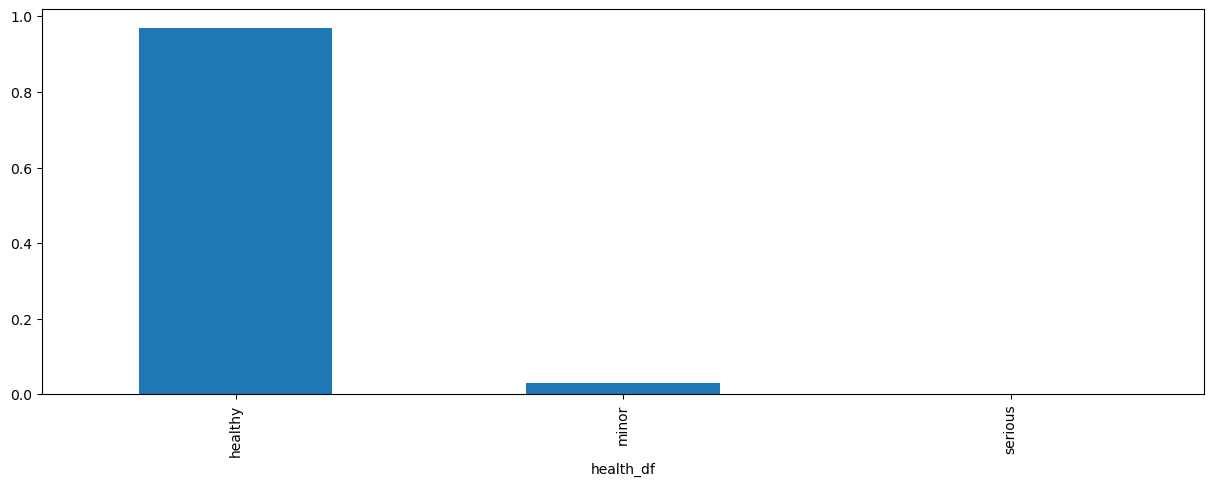

In [102]:
# Gráfico de Valores únicos con etiquetas
df.health_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             14993 non-null  int64  
 1   Name             13728 non-null  object 
 2   Age              14993 non-null  int64  
 3   Breed1           14993 non-null  int64  
 4   Breed2           14993 non-null  int64  
 5   Gender           14993 non-null  int64  
 6   Color1           14993 non-null  int64  
 7   Color2           14993 non-null  int64  
 8   Color3           14993 non-null  int64  
 9   MaturitySize     14993 non-null  int64  
 10  FurLength        14993 non-null  int64  
 11  Vaccinated       14993 non-null  int64  
 12  Dewormed         14993 non-null  int64  
 13  Sterilized       14993 non-null  int64  
 14  Health           14993 non-null  int64  
 15  Quantity         14993 non-null  int64  
 16  Fee              14993 non-null  int64  
 17  State       

### Quantity

In [104]:
# Valores nulos
df.Quantity.isna().sum()   

0

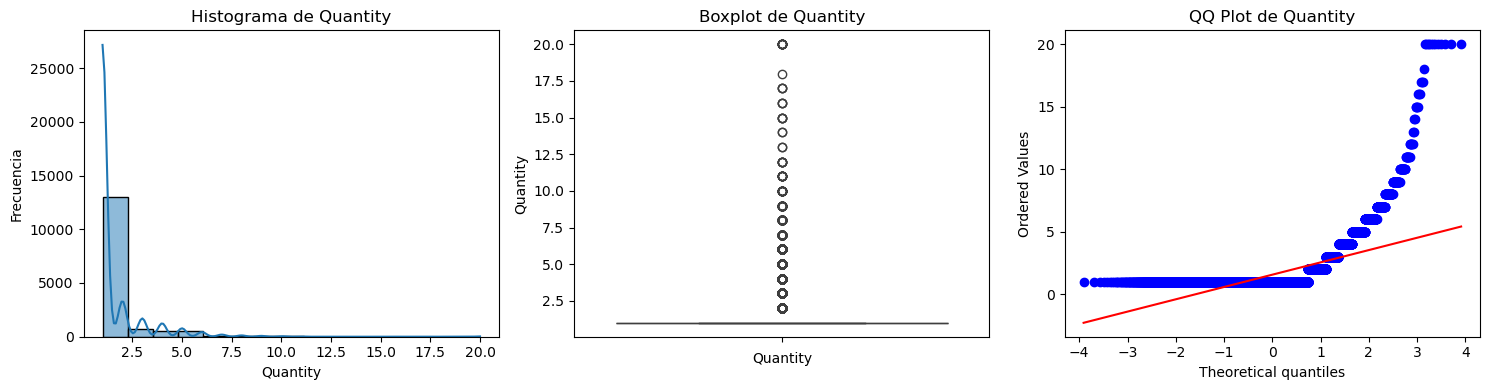

In [109]:
# Gráficos de distribución
graficos_distribucion(df, 'Quantity')

In [111]:
# Test de normalidad    
analizar_normalidad(df, 'Quantity')


--- Normalidad para Quantity ---
Shapiro-Wilk: W=0.4470, p=0.0000 -> No normal
D’Agostino-Pearson: stat=14292.4738, p=0.0000 -> No normal
Anderson-Darling: A=3137.0352
  Nivel 15.0%: crítico=0.5760 -> No normal
  Nivel 10.0%: crítico=0.6560 -> No normal
  Nivel 5.0%: crítico=0.7870 -> No normal
  Nivel 2.5%: crítico=0.9180 -> No normal
  Nivel 1.0%: crítico=1.0920 -> No normal


c:\Users\adria\anaconda3\envs\ldi2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14993.
  res = hypotest_fun_out(*samples, **kwds)


El campo `Quantity` muestra una distribución no normal, sin valores nulos o negativos.

In [112]:
df.Quantity.value_counts()

Quantity
1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
20       12
11       10
12        6
15        4
17        3
16        3
14        2
13        2
18        1
Name: count, dtype: int64

### Fee

In [114]:
df.Fee.value_counts()

Fee
0      12663
50       468
100      408
200      219
150      162
       ...  
170        1
135        1
14         1
89         1
190        1
Name: count, Length: 74, dtype: int64

La mayoria de las adopciones no tienen fee (son gratis)

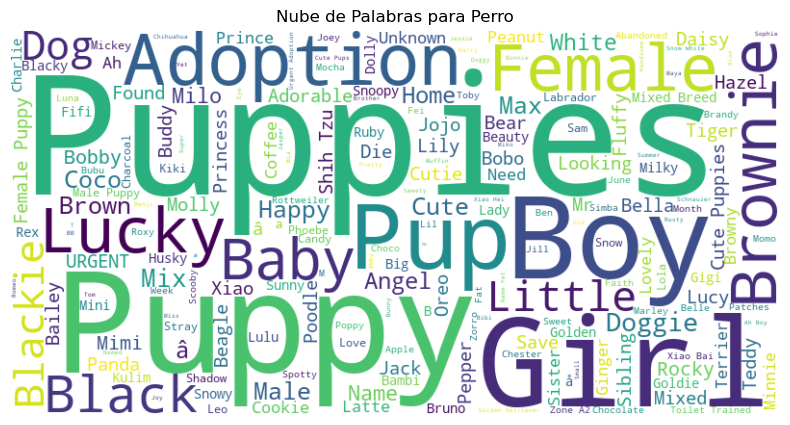

In [120]:
# Concatenar todos los nombres en una sola cadena, ignorando valores nulos
text = " ".join(df['Name'][df['Type']==1].dropna().astype(str).tolist())

# Opcional: definir un conjunto de stopwords para excluir palabras comunes que no aportan información
stopwords = set(STOPWORDS)
# Se pueden agregar más palabras a excluir, por ejemplo:
# stopwords.update(['dog', 'cat', 'mascota'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras para Perro')
plt.show()

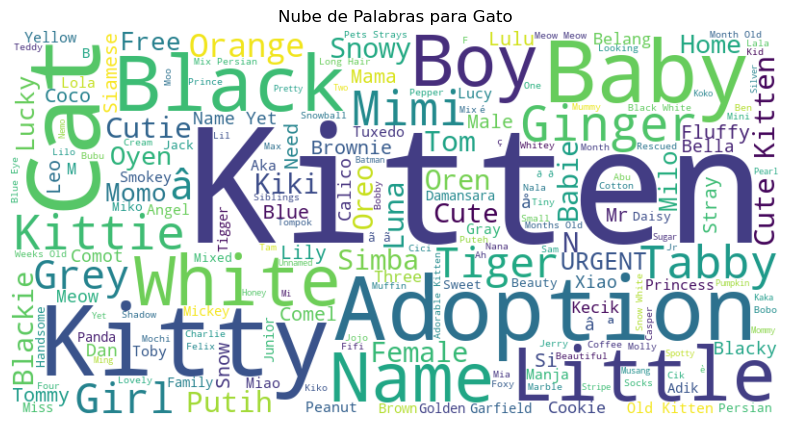

In [123]:
# Concatenar todos los nombres en una sola cadena, ignorando valores nulos
text = " ".join(df['Name'][df['Type']==2].dropna().astype(str).tolist())

# Opcional: definir un conjunto de stopwords para excluir palabras comunes que no aportan información
stopwords = set(STOPWORDS)
# Puedes agregar más palabras a excluir, por ejemplo:
# stopwords.update(['dog', 'cat', 'mascota'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=stopwords,
                      collocations=True).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras para Gato')
plt.show()

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             14993 non-null  int64  
 1   Name             13728 non-null  object 
 2   Age              14993 non-null  int64  
 3   Breed1           14993 non-null  int64  
 4   Breed2           14993 non-null  int64  
 5   Gender           14993 non-null  int64  
 6   Color1           14993 non-null  int64  
 7   Color2           14993 non-null  int64  
 8   Color3           14993 non-null  int64  
 9   MaturitySize     14993 non-null  int64  
 10  FurLength        14993 non-null  int64  
 11  Vaccinated       14993 non-null  int64  
 12  Dewormed         14993 non-null  int64  
 13  Sterilized       14993 non-null  int64  
 14  Health           14993 non-null  int64  
 15  Quantity         14993 non-null  int64  
 16  Fee              14993 non-null  int64  
 17  State       

## Target: `AdoptionSpeed`

In [125]:
# Valores nulos
df.AdoptionSpeed.isna().sum()

0

In [126]:
# Valores únicos
df.AdoptionSpeed.value_counts().sort_index()

AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: count, dtype: int64

In [127]:
# Proporción de Valores únicos
df.AdoptionSpeed.value_counts(normalize=True).round(2).sort_index()

AdoptionSpeed
0    0.03
1    0.21
2    0.27
3    0.22
4    0.28
Name: proportion, dtype: float64

<Axes: xlabel='AdoptionSpeed'>

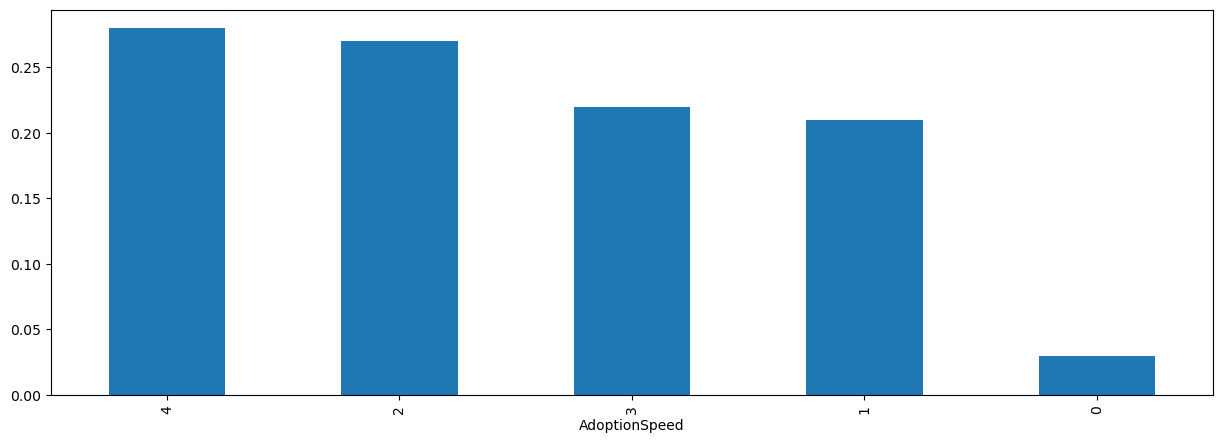

In [128]:
# Gráfico de Valores únicos con etiquetas
df.AdoptionSpeed.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

## Análisis Bivariado con Target

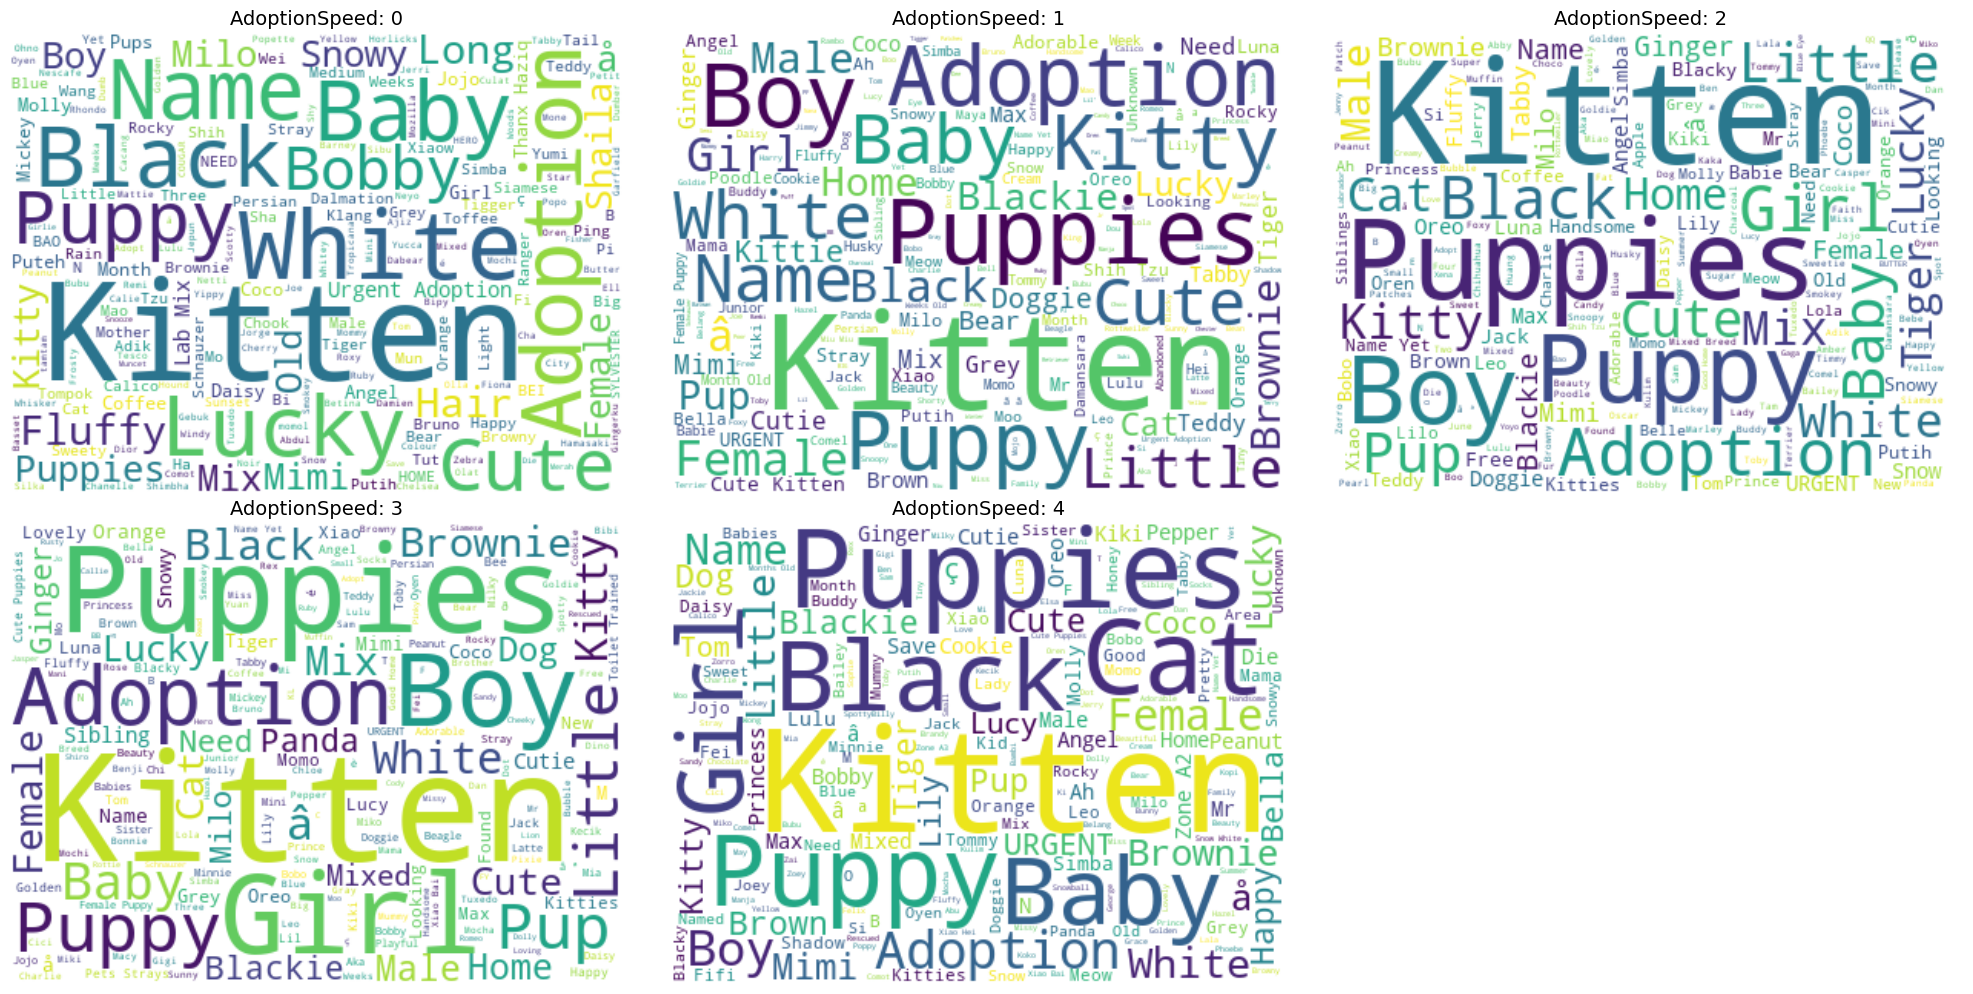

In [132]:
# Obtener los valores únicos de AdoptionSpeed (suponiendo que hay 6 categorías)
adoption_speeds = sorted(df['AdoptionSpeed'].unique())

# Crear la figura y subplots con 2 filas x 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Aplanar la matriz de ejes para iterar fácilmente
axs = axs.flatten()

# Iterar sobre cada valor de AdoptionSpeed y generar la nube de palabras
for idx, speed in enumerate(adoption_speeds):
    # Filtrar el DataFrame para el valor actual de AdoptionSpeed
    subset = df[df['AdoptionSpeed'] == speed]
    
    # Concatenar todos los nombres, ignorando valores nulos
    text = " ".join(subset['Name'].dropna().astype(str).tolist())
    
    # Generar la nube de palabras
    wordcloud = WordCloud(width=400, height=300,
                          background_color='white',
                          stopwords=stopwords,
                          collocations=True).generate(text)
    
    # Mostrar la nube en el subgráfico correspondiente
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].axis('off')
    axs[idx].set_title(f'AdoptionSpeed: {speed}', fontsize=14)

# Si hay menos de 6 categorías, ocultar los ejes sobrantes
for j in range(idx + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## Análisis Multivariado
En principio se establecen dos niveles de comparación:
- Con la variable target `AdoptionSpeed`
- Con `Type` (perro o gato)

### Relación con `AdoptionSpeed`
### Con `Type`
#### Visualización de la distribución de AdoptionSpeed por Type
- Gráfico de barras agrupadas: Muestra la frecuencia absoluta de cada nivel de AdoptionSpeed para cada Type.
-Gráfico de barras apiladas o de proporciones: Permite ver las proporciones relativas.

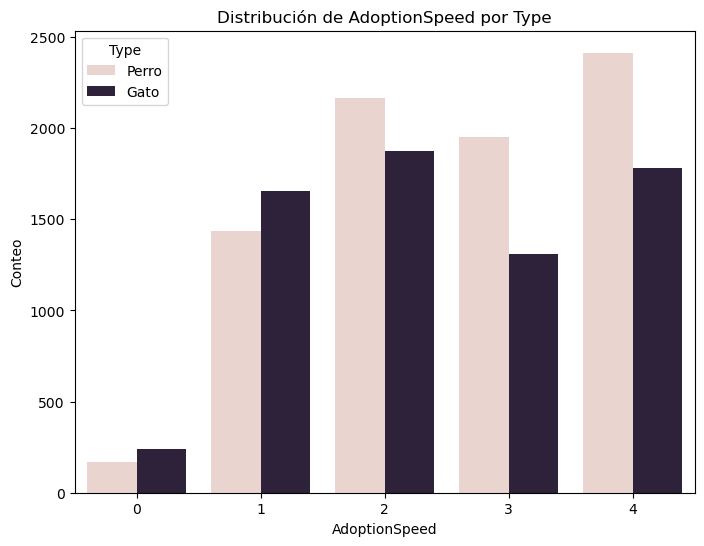

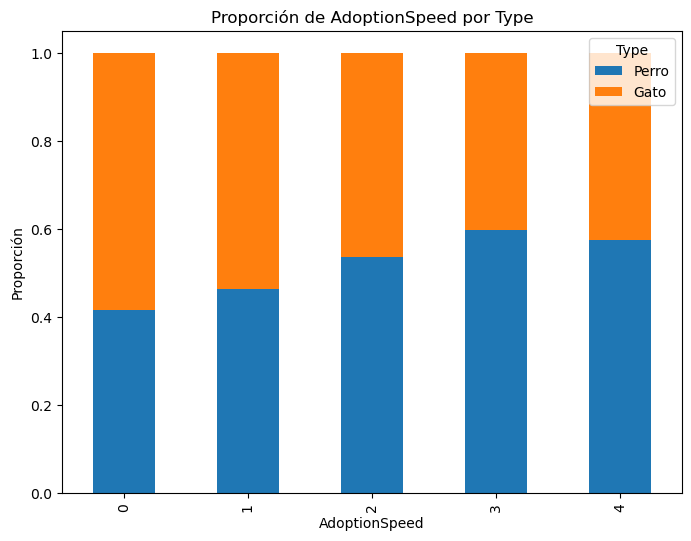

In [133]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Type')
plt.title('Distribución de AdoptionSpeed por Type')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Type', labels=['Perro', 'Gato'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_type_ct = pd.crosstab(df['AdoptionSpeed'], df['Type'], normalize='index')
adoption_type_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Type')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Type', labels=['Perro', 'Gato'])  # Ajusta según la codificación real
plt.show()

##### Consideraciones de la visualización entre `AdoptionSpeed` y `Type`
- `AdoptionSpeed` 0 (adopción más rápida): Tanto perros como gatos presentan relativamente pocos casos en la categoría 0, lo que indica que no es muy común que las mascotas sean adoptadas “inmediatamente”.
- `AdoptionSpeed` intermedios (1, 2, 3): La mayor concentración de casos para ambos tipos se ubica en los valores 2 y 3. Los perros parecen tener un pico ligeramente mayor en AdoptionSpeed 2 y 3, mientras que los gatos muestran un recuento un poco más alto en AdoptionSpeed 1.
- `AdoptionSpeed` 4 (adopción más tardía o no adoptado): Se ve que los perros tienen un conteo algo mayor en el nivel 4, en comparación con los gatos, lo que podría indicar que, proporcionalmente, hay más perros que terminan adoptados muy tarde (o incluso no adoptados).
- El gráfico indica que no todas las mascotas se adoptan con la misma rapidez. Hay un grupo pequeño en la categoría 0 (adopción muy rápida), un volumen considerable en las categorías 2 y 3, y un grupo notable en la categoría 4. Parecería que, visualmente, que el tipo de mascota (perro vs. gato) podría influir en la rapidez de adopción. Los perros tienen mayor conteo a medida que aumentan las categorias, mientras que los gatos se concentran un poco más en las categorías intermedias.
- Finalmente, el gráfico sugiere que, si bien hay similitudes en las distribuciones de perros y gatos, sí existen diferencias importantes en los niveles de `AdoptionSpeed`, sobre todo en la categoría más tardía (4). 

#### Análisis Estadístico

Analizar si hay dependencia estadística entre el tipo de mascota (Type: perro o gato) y la velocidad de adopción (AdoptionSpeed):

. Chi-cuadrado de independencia: test estadístico.

. Cramér's V: para medir la fuerza de la asociación.

In [134]:
from scipy.stats import chi2_contingency

# Crear la tabla de contingencia
contingency_table = pd.crosstab(df['AdoptionSpeed'], df['Type'])
print("Tabla de contingencia:")
print(contingency_table)

# Ejecutar el test de Chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-cuadrado:", chi2)
print("Grados de libertad:", dof)
print("p-value:", p_value)

Tabla de contingencia:
Type              1     2
AdoptionSpeed            
0               170   240
1              1435  1655
2              2164  1873
3              1949  1310
4              2414  1783
Chi-cuadrado: 162.1682083216616
Grados de libertad: 4
p-value: 5.010488338487401e-34


Hipótesis nula (H₀): AdoptionSpeed y Type son independientes.

p-value muy bajo (< 0.05) → se rechaza H₀.

Conclusión: hay dependencia estadística entre tipo de mascota y velocidad de adopción.

In [135]:
# Calcular Cramér's V
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape)-1
cramers_v = np.sqrt(chi2/(n*min_dim))
print("Cramér's V:", cramers_v)

Cramér's V: 0.10400125709240224


Mide la fuerza de la asociación entre dos variables categóricas.

Va de 0 (ninguna relación) a 1 (relación perfecta).

Cramér's V = 0.104 → asociación débil pero estadísticamente significativa.

Aunque existe una diferencia detectable entre las categorías (test de chi cuadrado), el impacto real o la magnitud de esta diferencia es limitada (grado de asociación entre ambas variables con el test de Cramer's V). Este resultado es importante para entender que, a pesar de ser significativa, la variable Type podría no ser un factor determinante fuerte en la velocidad de adopción, lo que sugiere que otros factores también deben considerarse en análisis o modelos predictivos.

### Con `Age`
#### Análisis Descriptivo de la distribución de `Age` segun `AdoptionSpeed`


In [97]:
# Estadísticas descriptivas de Age agrupadas por AdoptionSpeed
age_summary = df.groupby('AdoptionSpeed')['Age'].describe()
print(age_summary)

                count       mean        std  min  25%  50%   75%    max
AdoptionSpeed                                                          
0               410.0  10.451220  17.775118  0.0  2.0  3.0  12.0  120.0
1              3090.0   8.488350  15.746187  0.0  2.0  2.0   6.0  147.0
2              4037.0   8.823631  16.779013  0.0  2.0  3.0   6.0  156.0
3              3259.0  10.189936  18.672104  0.0  2.0  3.0   9.0  212.0
4              4197.0  13.667858  20.177460  0.0  3.0  6.0  15.0  255.0


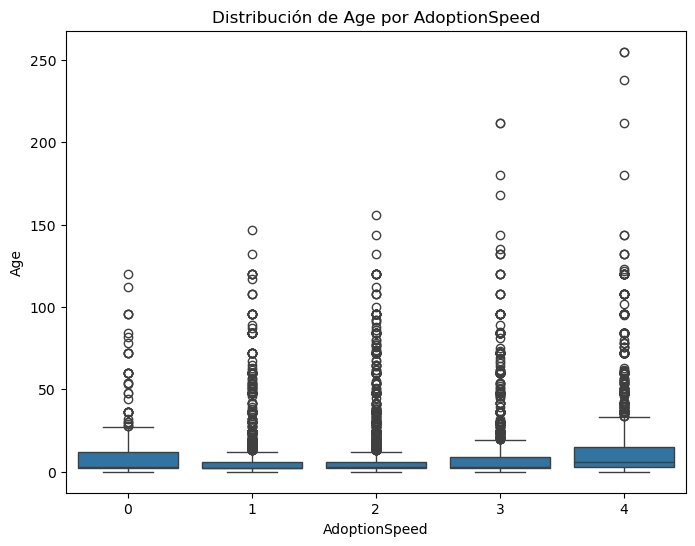

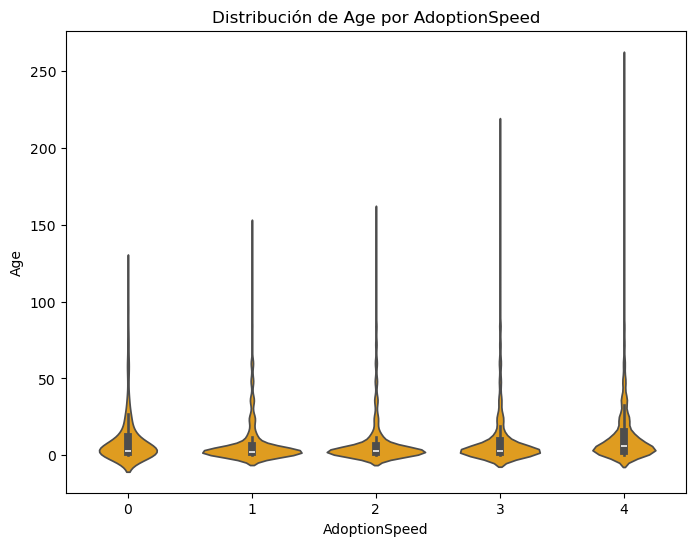

In [99]:
# Gráfico de caja (boxplot)
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='AdoptionSpeed', y='Age')
plt.title('Distribución de Age por AdoptionSpeed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Age')
plt.show()

# Gráfico de violín
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='AdoptionSpeed', y='Age', color='orange')
plt.title('Distribución de Age por AdoptionSpeed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Age')
plt.show()

Consideraciones:
1.	Distribución Altamente Sesgada (Skewed)
	- En ambos gráficos se aprecia que la mayoría de los datos de la edad se concentran cerca de valores bajos (en la parte inferior), mientras que existe un número significativo de valores atípicos que se extienden hacia la parte superior (algunos llegan hasta o superan los 200).
	- Esto sugiere que la edad de la mayoría de las mascotas es relativamente baja, pero hay una minoría de casos con edades muy elevadas.
2.	Medianas Similares entre Categorías
	- Tanto en el boxplot como en el violin plot, se observa que la mediana de la edad (la línea dentro de cada “caja” o el recuadro en la parte más densa del violín) se ubica en un rango relativamente cercano para todas las categorías de AdoptionSpeed (0 a 4).
	- Esto indica que, en promedio, las mascotas adoptadas muy rápido (AdoptionSpeed=0) no difieren sustancialmente en edad de aquellas que tardan más (AdoptionSpeed=4).
3.	Presencia de Outliers
	- Los puntos que aparecen por encima de los “bigotes” (whiskers) en el boxplot se consideran valores atípicos, reflejando edades mucho mayores que la mayoría de las observaciones.
	- La extensión vertical en los violin plots corrobora que, aunque la mayoría de los registros se concentran en edades más jóvenes, hay un grupo reducido con edades muy altas.
4.	Densidad y Forma de la Distribución
	- El violin plot muestra la densidad de la edad en cada categoría de AdoptionSpeed. Cada “violín” es bastante estrecho en la parte superior, lo que confirma que hay menos mascotas con edades muy elevadas, pero al mismo tiempo el rango máximo llega a valores altos.
	- En la parte inferior, los “violines” se ensanchan, señal de que la mayoría de las mascotas se encuentran en edades bajas (con un pico de densidad concentrado en los primeros meses/años).
5.	Conclusión Preliminar
	- Visualmente, no se observan diferencias drásticas en la edad promedio o mediana a medida que varía la velocidad de adopción.
	

#### Test Estadísticos


In [101]:
# Extraer la variable Age para cada grupo de AdoptionSpeed
groups = [group["Age"].values for name, group in df.groupby("AdoptionSpeed")]

# Realizar el test de Kruskal-Wallis
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis stat:", stat)
print("p-value:", p_value)

Kruskal-Wallis stat: 823.1138148978662
p-value: 7.561186820617216e-177


In [102]:
# Número de grupos (suponiendo 5 categorías para AdoptionSpeed)
k = df['AdoptionSpeed'].nunique()  # debería dar 5

# Total de observaciones
n = len(df)

# Estadístico de Kruskal-Wallis (ya calculado)
H = 823.1138148978662

# Calcular epsilon²
epsilon_squared = (H - k + 1) / (n - k)
print("Epsilon squared (tamaño del efecto):", epsilon_squared)

Epsilon squared (tamaño del efecto): 0.05465130870682321


El test de Kruskal-Wallis muestra un estadístico de 823.11 y un p-value extremadamente bajo (≈ 7.56e-177), lo que indica que existen diferencias significativas en la distribución de la edad entre las categorías de AdoptionSpeed. Esto significa que, al menos, dos de los grupos difieren en sus distribuciones de edad de manera no aleatoria.

Al calcular el tamaño del efecto usando el estimador de $\epsilon^2$ cuadrado adaptado a Kruskal-Wallis ($\epsilon^2$), Este valor (aproximadamente 0.06) indicaría que solo alrededor del 6% de la variabilidad en Age se explica por las diferencias en las categorías de AdoptionSpeed. En otras palabras, a pesar de que el test de Kruskal-Wallis indica diferencias significativas, el tamaño del efecto es pequeño, lo que sugiere que la influencia práctica de AdoptionSpeed sobre la edad es limitada.

##### Consideradiones
- La edad de la mascota podría tener un impacto en la velocidad de adopción. Si se observa que existen diferencias significativas y con un tamaño de efecto razonable, `Age` puede ser una variable importante en modelos predictivos.


### Con `Breed1` y `Breed2`
Cuando se cuenta con dos campos de raza (por ejemplo, Breed1 y Breed2) es importante plantear un análisis EDA que permita comprender tanto la distribución individual de cada uno como su interacción, y cómo se relacionan con la variable objetivo (AdoptionSpeed). A continuación, se sugieren varios pasos y consideraciones:

⸻

1. Análisis Individual de Breed1 y Breed2
	•	Frecuencia y Distribución:
	•	Realiza un análisis de frecuencias para cada campo por separado. Dado que estas variables pueden tener una alta cardinalidad (muchos niveles), observa cuáles son las razas más frecuentes.
	•	Utiliza gráficos de barras o tablas de frecuencias para visualizar las 10 o 20 razas más comunes.
	•	Valores Faltantes y Codificación:
	•	Verifica la cantidad de registros que tienen valores nulos o códigos especiales.
	•	Es importante saber si Breed2 se utiliza para representar “sin raza secundaria” o similar.

⸻

2. Análisis de la Relación entre Breed1 y Breed2
	•	Combinaciones de Razas:
	•	Crea una tabla de contingencia que muestre la relación entre Breed1 y Breed2.
	•	Esto permite identificar si existen combinaciones de razas que se presentan con mayor frecuencia o si ciertas razas secundarias se asocian sistemáticamente con determinadas razas primarias.
	•	Visualización:
	•	Utiliza gráficos de mosaico o mapas de calor para representar la frecuencia conjunta.
	•	Esto ayudará a detectar patrones de co-ocurrencia.

⸻

3. Relación entre las Razas y la Variable Objetivo (AdoptionSpeed)
	•	Tablas de Contingencia y Distribución de la Variable Target:
	•	Calcula la distribución de AdoptionSpeed para cada raza (al menos para las más frecuentes) en Breed1 y, de ser relevante, en Breed2.
	•	Considera agrupar las razas menos frecuentes en una categoría “Otros” para evitar celdas con muy pocos registros.
	•	Visualización:
	•	Usa gráficos de barras agrupadas o apiladas para comparar la distribución de AdoptionSpeed entre las principales categorías de raza.
	•	Otra opción es utilizar boxplots si se analiza una variable continua derivada o resumida (por ejemplo, tiempo de adopción si se puede transformar).
	•	Test Estadísticos:
	•	El test de chi-cuadrado puede ser utilizado para evaluar la independencia entre la raza y AdoptionSpeed.
	•	Ten en cuenta que, debido a la alta cardinalidad, algunas combinaciones pueden tener frecuencias muy bajas. En estos casos, podrías agrupar categorías o usar tests exactos en subconjuntos.

⸻

4. Consideraciones de Modelado
	•	Reducción de Cardinalidad:
	•	Debido a la alta cantidad de niveles en las variables de raza, podrías considerar agrupar razas similares (por tamaño, temperamento, o alguna variable derivada) para simplificar el análisis y la modelización.
	•	Interacciones y Efectos Conjuntos:
	•	Analiza si la combinación de Breed1 y Breed2 (por ejemplo, la presencia de una segunda raza en ciertos casos) influye de forma distinta en la variable objetivo.
	•	Si es factible, prueba modelos que incluyan interacciones entre las variables de raza y otras características (como Type u Age) para ver si hay efectos combinados que expliquen mejor AdoptionSpeed.
	•	Análisis Exploratorio vs. Modelado:
	•	Es aconsejable realizar primero el análisis EDA individual e interrelacional entre Breed1 y Breed2 para comprender bien la estructura y distribución de las razas.
	•	Luego, se puede profundizar en cómo estas variables (individualmente o combinadas) se relacionan con AdoptionSpeed, lo que ayudará a decidir cómo incorporarlas en futuros modelos predictivos.

⸻

Resumen
	1.	Análisis individual: Explora la frecuencia y distribución de Breed1 y Breed2.
	2.	Relación entre razas: Realiza un análisis de la asociación entre Breed1 y Breed2 para entender combinaciones comunes.
	3.	Asociación con la variable objetivo: Examina cómo varía AdoptionSpeed según las diferentes razas, usando tablas de contingencia, gráficos y tests estadísticos (como chi-cuadrado), considerando la necesidad de agrupar categorías con pocas observaciones.
	4.	Preparación para modelado: Considera la reducción de la cardinalidad y la exploración de interacciones, ya que la inclusión de variables de raza puede aportar información relevante pero debe manejarse cuidadosamente debido a la cantidad de niveles.

Este enfoque integral permitirá extraer información valiosa sobre el rol de las variables de raza en la velocidad de adopción, y ayudará a orientar decisiones en la construcción de modelos predictivos más robustos y efectivos.

In [104]:
df_breedName_chat = df[['AdoptionSpeed', 'BreedName1', 'BreedName2']].copy()

In [105]:
df_breedName_chat.to_csv('df_breedName_chat.csv', index=False)

In [106]:
df_breedName_chat.head()

AdoptionSpeed            BreedName1 BreedName2
0              2                 Tabby        NaN
1              0  Domestic Medium Hair        NaN
2              3           Mixed Breed        NaN
3              2           Mixed Breed        NaN
4              2           Mixed Breed        NaN

In [108]:
# Cargar el dataset
df_breed = pd.read_csv('df_breedName_chat.csv')

# Tabla de contingencia entre Breed1 y Breed2
contingency = pd.crosstab(df_breed['Breed1'], df_breed['Breed2'])
print(contingency)

Breed2   0    1    2    4    5    10   14   16   17   18   ...  296  299  300  \
Breed1                                                     ...                  
0          0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1          2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3          1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
5          1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
7          1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
303       17    0    0    0    0    0    0    0    0    0  ...    0    1    0   
304        3    0    0    0    0    0    0    0    0    0  ...    0    0    0   
305        6    0    0    0    0    0    0    0    0    0  ...    0    0    0   
306       32    0    0    0    0    0    0    0    0    0  ...    0    1    0   
307     4535    1    0    0 

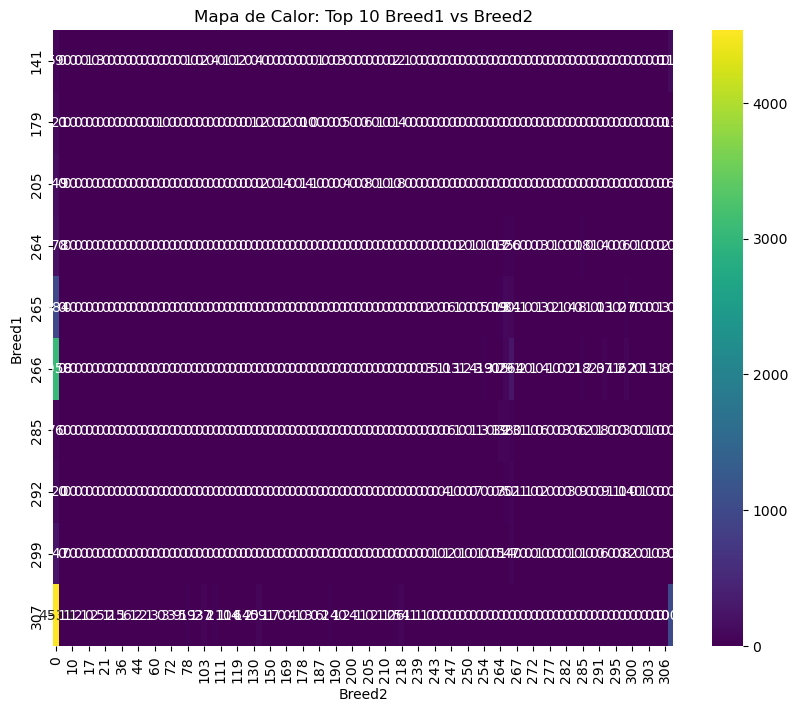

In [109]:
# Seleccionar, por ejemplo, las 10 razas más frecuentes en Breed1
top_breeds = df_breed['Breed1'].value_counts().head(10).index
contingency_top = pd.crosstab(df_breed[df_breed['Breed1'].isin(top_breeds)]['Breed1'],
                              df_breed[df_breed['Breed1'].isin(top_breeds)]['Breed2'])

plt.figure(figsize=(10,8))
sns.heatmap(contingency_top, annot=True, fmt="d", cmap='viridis')
plt.title('Mapa de Calor: Top 10 Breed1 vs Breed2')
plt.xlabel('Breed2')
plt.ylabel('Breed1')
plt.show()

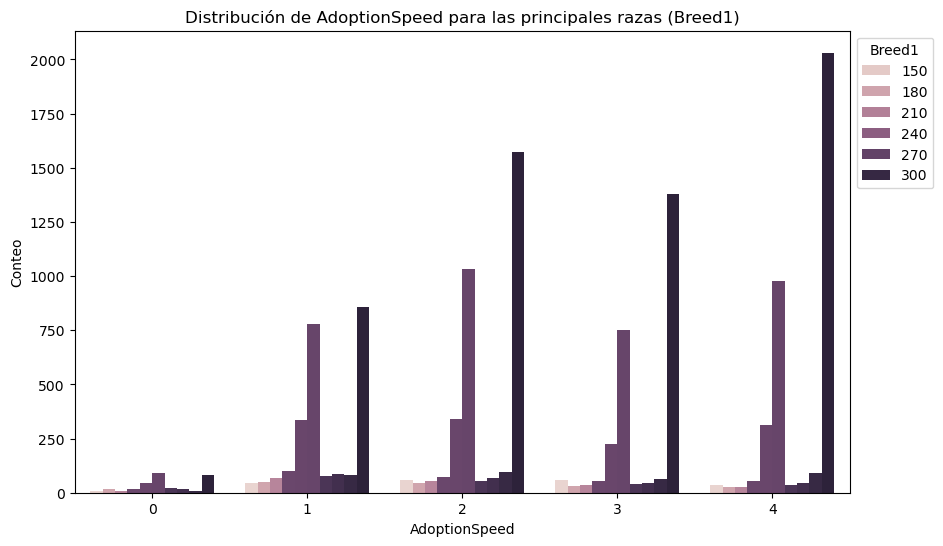

In [110]:
# Ejemplo: filtrar para las 10 razas más comunes en Breed1 y analizar AdoptionSpeed
top_breeds = df_breed['Breed1'].value_counts().head(10).index
# Suponiendo que el dataset principal 'df' tenga una columna 'Breed1' y 'AdoptionSpeed'
df_top = df[df['Breed1'].isin(top_breeds)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top, x='AdoptionSpeed', hue='Breed1')
plt.title('Distribución de AdoptionSpeed para las principales razas (Breed1)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Breed1', bbox_to_anchor=(1,1))
plt.show()

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             14993 non-null  int64  
 1   Name             13728 non-null  object 
 2   Age              14993 non-null  int64  
 3   Breed1           14993 non-null  int64  
 4   Breed2           14993 non-null  int64  
 5   Gender           14993 non-null  int64  
 6   Color1           14993 non-null  int64  
 7   Color2           14993 non-null  int64  
 8   Color3           14993 non-null  int64  
 9   MaturitySize     14993 non-null  int64  
 10  FurLength        14993 non-null  int64  
 11  Vaccinated       14993 non-null  int64  
 12  Dewormed         14993 non-null  int64  
 13  Sterilized       14993 non-null  int64  
 14  Health           14993 non-null  int64  
 15  Quantity         14993 non-null  int64  
 16  Fee              14993 non-null  int64  
 17  State       

# 🐾 PetFinder Adoption Prediction - EDA

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]


In [137]:
# Reemplazar los paths según donde tengas tus archivos
train = pd.read_csv('train/train.csv')
breed = pd.read_csv('breed_labels.csv')
color = pd.read_csv('color_labels.csv')
state = pd.read_csv('state_labels.csv')

train.shape, train.head()


((14993, 24),
    Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
 0     2       Nibble    3     299       0       1       1       7       0   
 1     2  No Name Yet    1     265       0       1       1       2       0   
 2     1       Brisco    1     307       0       1       2       7       0   
 3     1         Miko    4     307       0       2       1       2       0   
 4     1       Hunter    1     307       0       1       1       0       0   
 
    MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
 0             1          1           2         2           2       1   
 1             2          2           3         3           3       1   
 2             2          2           1         1           2       1   
 3             2          1           1         1           2       1   
 4             2          1           2         2           2       1   
 
    Quantity  Fee  State                         RescuerID  VideoAmt  \
 0  

In [138]:
train.isnull().sum().sort_values(ascending=False)

Name             1265
Description        13
Type                0
PhotoAmt            0
PetID               0
VideoAmt            0
RescuerID           0
State               0
Fee                 0
Quantity            0
Health              0
Sterilized          0
Dewormed            0
Vaccinated          0
FurLength           0
MaturitySize        0
Color3              0
Color2              0
Color1              0
Gender              0
Breed2              0
Breed1              0
Age                 0
AdoptionSpeed       0
dtype: int64

In [139]:
train['Name'] = train['Name'].fillna('Unnamed')
train['Has_name'] = 1
train.loc[train['Name'] == 'Unnamed', 'Has_name'] = 0

In [140]:
train['Type'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

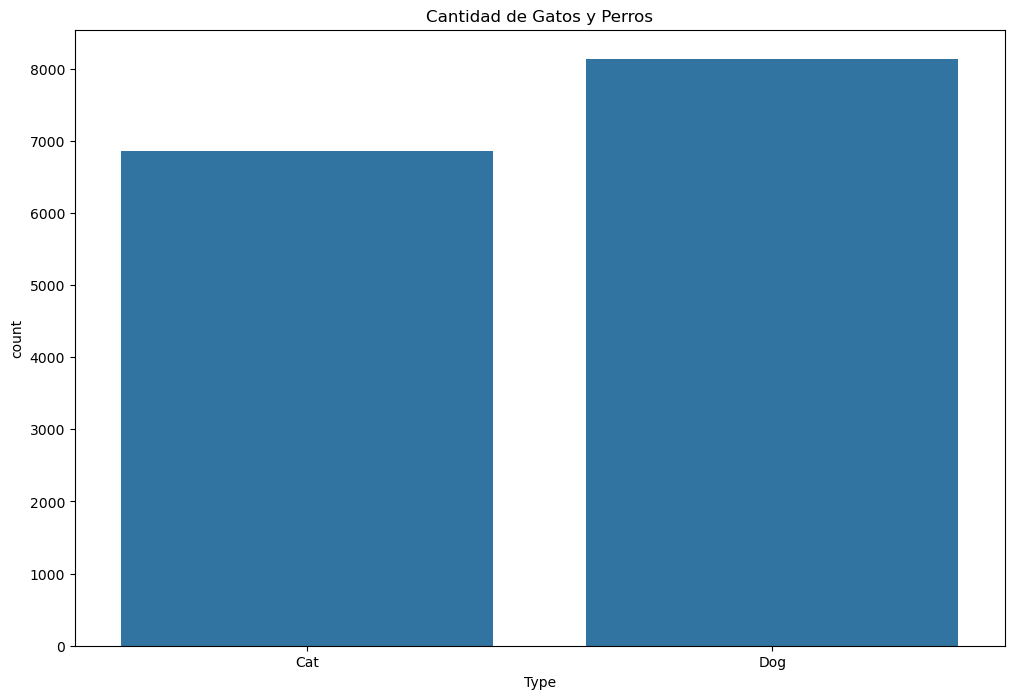

In [141]:
sns.countplot(x='Type', data=train)
plt.title('Cantidad de Gatos y Perros')
plt.show()

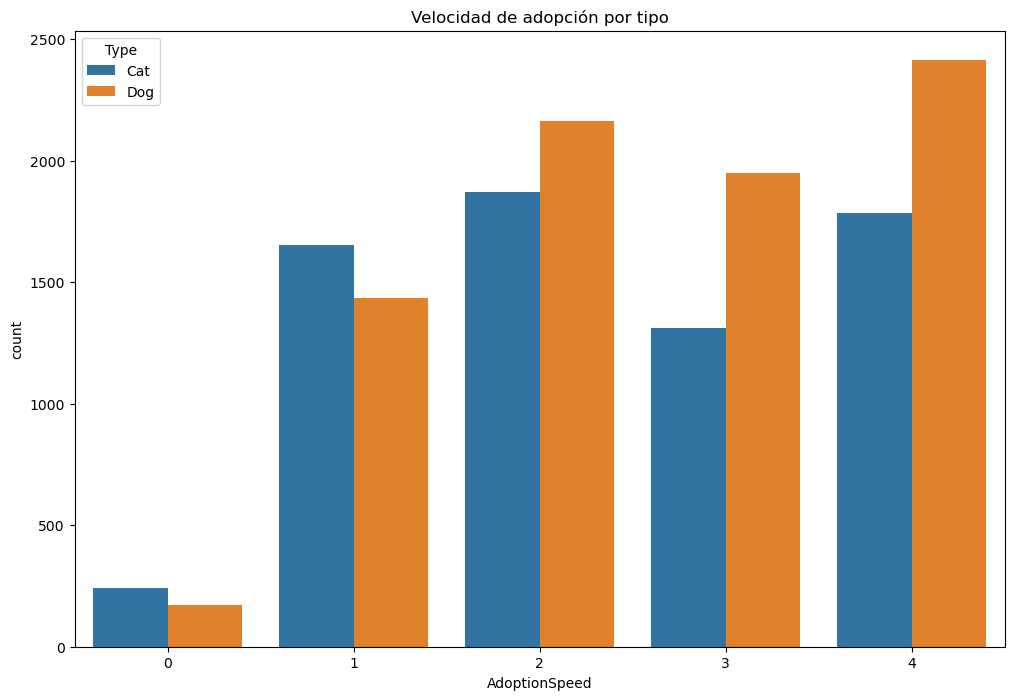

In [142]:
sns.countplot(x='AdoptionSpeed', data=train, hue='Type')
plt.title('Velocidad de adopción por tipo')
plt.show()

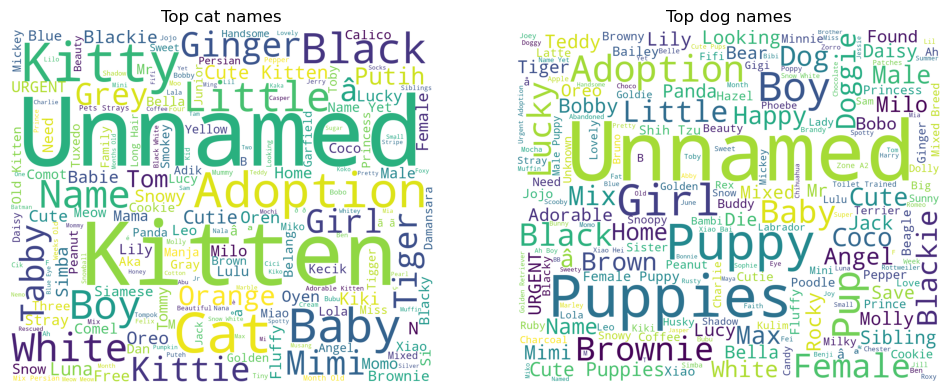

In [143]:
plt.subplot(1, 2, 1)
text_cat = ' '.join(train.loc[train['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(train.loc[train['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")
plt.show()


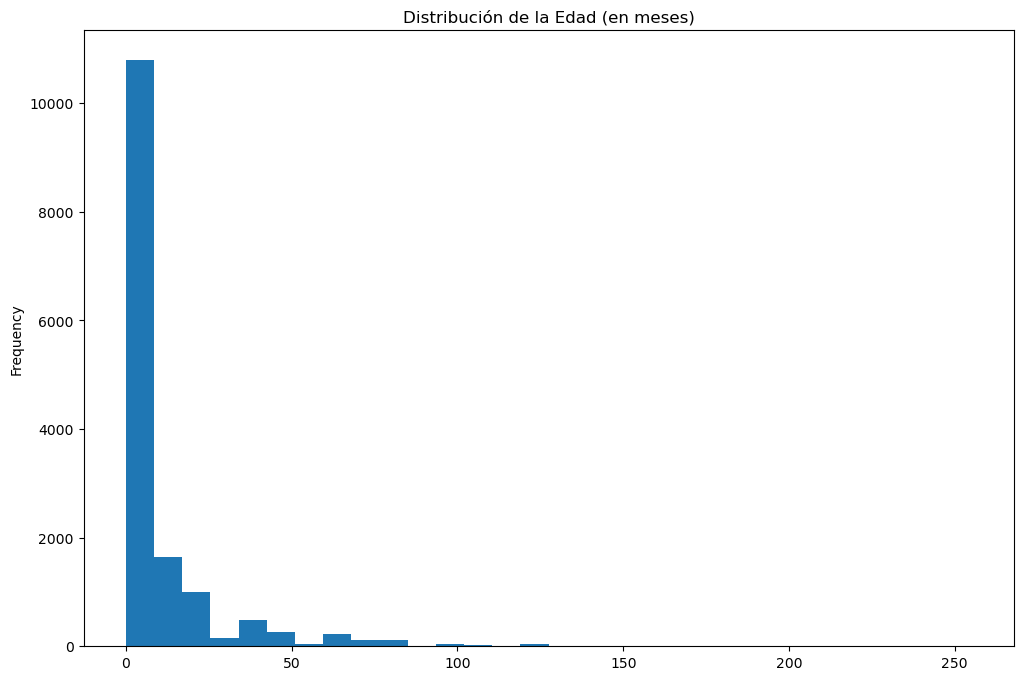

In [144]:
train['Age'].plot(kind='hist', bins=30)
plt.title('Distribución de la Edad (en meses)')
plt.show()

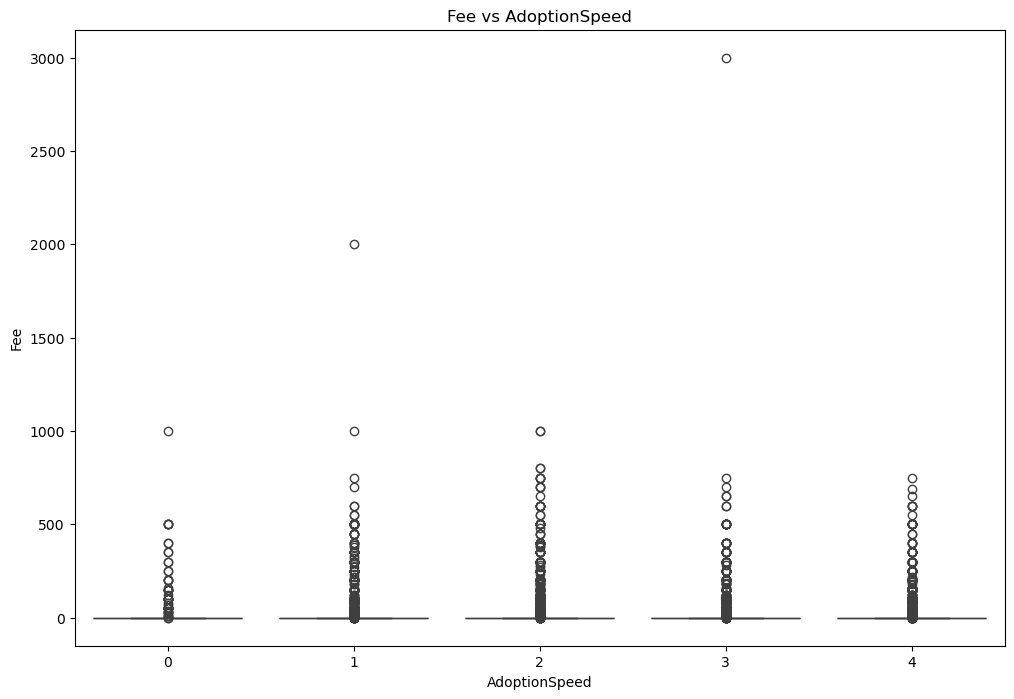

In [145]:
sns.boxplot(data=train, x='AdoptionSpeed', y='Fee')
plt.title('Fee vs AdoptionSpeed')
plt.show()

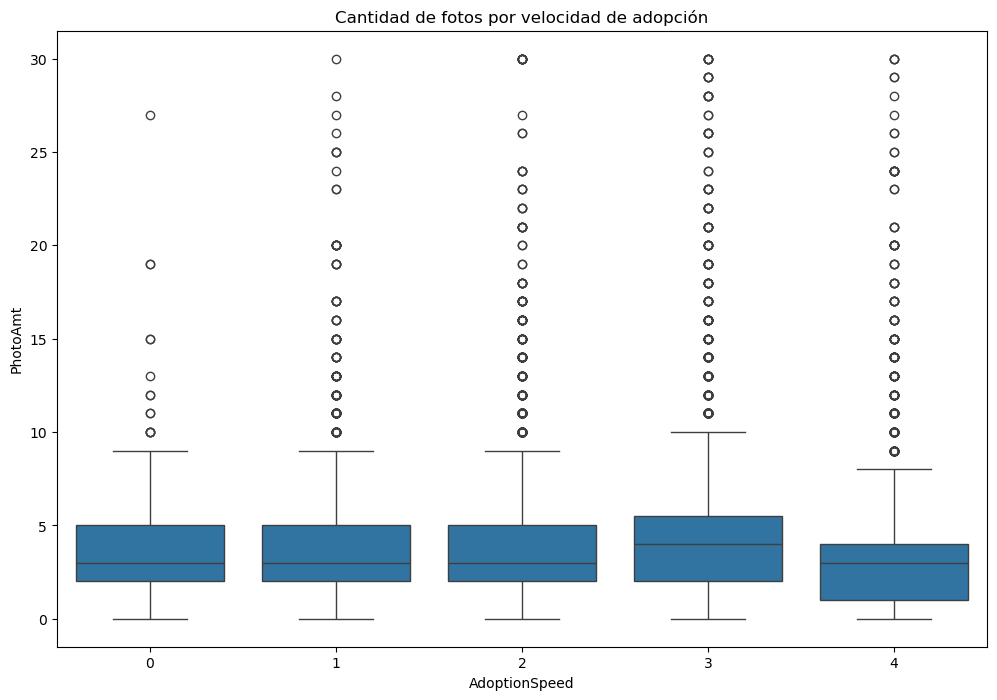

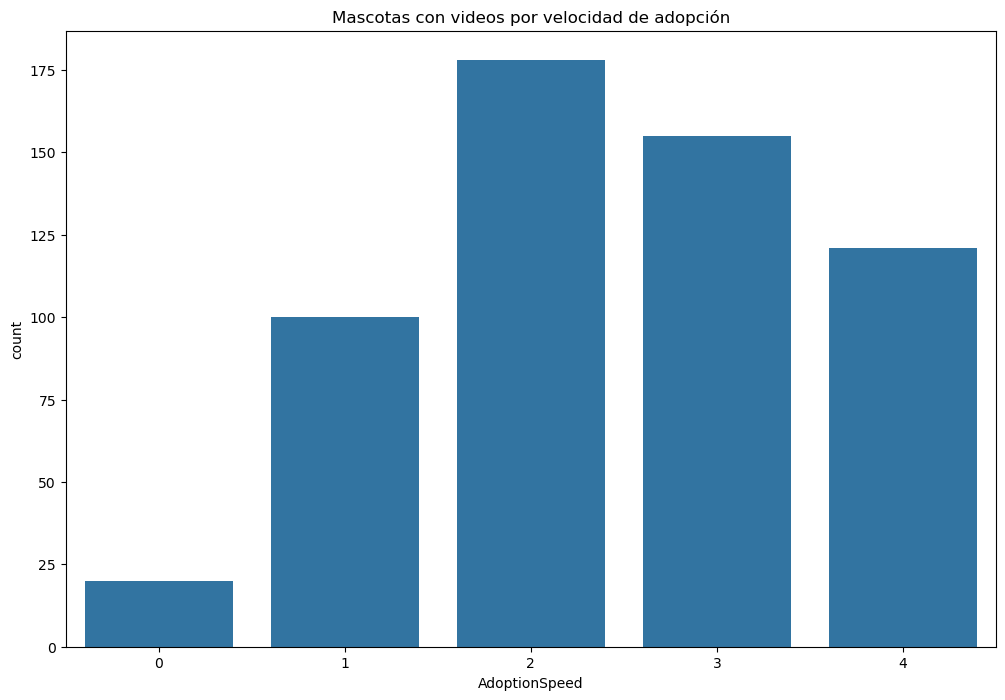

In [146]:
sns.boxplot(data=train, x='AdoptionSpeed', y='PhotoAmt')
plt.title('Cantidad de fotos por velocidad de adopción')
plt.show()

sns.countplot(data=train[train['VideoAmt'] > 0], x='AdoptionSpeed')
plt.title('Mascotas con videos por velocidad de adopción')
plt.show()
